In [1]:
from UNetPyTorch import *

import xarray as xr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

import cartopy
import cartopy.crs as ccrs

from torch.utils.data import DataLoader, Dataset

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

### Model

In [14]:
class build_res_unet(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c, 64, kernel_size=1, padding=0) # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, out_c, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output

class WeatherData(Dataset):
    def __init__(self, dataset: xr.Dataset, window_size: int = 24, steps: int = 3, auto = False):
        self.dataset = dataset
        self.window_size = window_size
        self.steps = steps
        self.calculate_wind_speed()
        self.dataset = self.dataset.sortby('latitude')

        self.min_value = self.dataset.wspd.min().item()
        self.max_value = self.dataset.wspd.max().item()
        

        if auto:
            self.window_dataset()
            self.split_data()    
            self.normalize_data()    

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.F_train[idx], self.y_train[idx]
    
    def subset_data(self, coarsen = 1):
        if coarsen > 1:
            lat_slice = slice(1, 33, coarsen)
            lon_slice = slice(3, 67, coarsen)
        else:
            lat_slice = slice(1, 33)  
            lon_slice = slice(3, 67)

        self.dataset = self.dataset.isel(latitude=lat_slice, longitude=lon_slice)

    def calculate_wind_speed(self):
        self.dataset['wspd'] = np.sqrt(self.dataset.u**2 + self.dataset.v**2).astype(np.float32)
        self.dataset.attrs['wspd_units'] = 'm/s'
        # self.dataset['wdir'] = np.arctan2(self.dataset.v, self.dataset.u) * 180 / np.pi
        # self.dataset.attrs['wdir_units'] = 'degrees'

    def window_dataset(self, variable: str = 'wspd'):
        time_dim = self.dataset.sizes['time']
        total_windows = time_dim - self.window_size - self.steps

        # Preallocate arrays for better performance
        features = np.empty((total_windows, self.window_size, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        targets = np.empty((total_windows,  self.steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        forcings = np.empty((total_windows, 2), dtype=np.int32)
        time_values = np.empty((total_windows, self.window_size), dtype='datetime64[ns]')

        # Slice the dataset for all the time values at once
        dataset_time = self.dataset.time.values
        dataset_hour = self.dataset.time.dt.hour.values
        dataset_month = self.dataset.time.dt.month.values

        # Vectorized slicing
        for i in range(total_windows):
            print(f'{i}/{total_windows}', end='\r')
            
            # Slice features, targets, time values, and forcings in batches
            features[i] = self.dataset[variable].isel(time=slice(i, i + self.window_size)).values
            targets[i] = self.dataset[variable].isel(time=slice(i + self.window_size, i + self.window_size + self.steps)).values
            time_values[i] = dataset_time[i:i + self.window_size]

            # Hour and month forcings
            forcings[i] = [dataset_hour[i + self.window_size], dataset_month[i + self.window_size]]

        # Save arrays as attributes
        self.features = features
        self.targets = targets
        self.forcings = forcings
        self.time_values = time_values

        print('Windowed...')

    def split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training, validation, and test sets.
        """

        print('Splitting...')
        self.X_train, self.X_test, self.y_train, self.y_test, self.F_train, self.F_test, self.T_train, self.T_test = train_test_split(
            self.features, self.targets, self.forcings, self.time_values,
            test_size= test_size)
     
        print('Shuffling...')
        
        self.X_train, self.y_train, self.F_train, self.T_train = shuffle(self.X_train, self.y_train, self.F_train, self.T_train, random_state=random_state)

    def normalize_data(self):
        self.X_train = (self.X_train - self.min_value) / (self.max_value - self.min_value)
        self.y_train = (self.y_train - self.min_value) / (self.max_value - self.min_value)
        self.X_test = (self.X_test - self.min_value) / (self.max_value - self.min_value)
        self.y_test = (self.y_test - self.min_value) / (self.max_value - self.min_value)

    def plot_from_ds(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.features[seed]
        targets = self.targets[seed]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def plot_from_data(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.X_test[seed:seed+1]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[1]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

class TorchWeatherModel(WeatherData):
    def __init__(self, ds: xr.Dataset, window_size: int = 24, steps: int = 3):
        super().__init__(dataset=ds, window_size=window_size, steps=steps, auto=True)

        print('Class setup done...')

    def assign_model(self, model):
        self.model = model

    def train_single(self, epochs=10, save_path=None, patience=5):
        if save_path is None:
            save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model.to(device)
        self.model.train()

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            epoch_loss = 0
            for X_batch, F_batch, y_batch in DataLoader(self, batch_size=32, shuffle=True):
                X_batch = X_batch.to(device)
                F_batch = F_batch.to(device)
                y_batch = y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = self.model(X_batch) # , F_batch
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)

            avg_loss = epoch_loss / len(self.X_train)  # Assuming self.X_train is used for training

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')

            # Checkpointing
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f'Saved best model to {save_path}')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    def predict(self, X, F):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X).float()
            F = torch.tensor(F).float()
            return self.model(X, F).numpy()
        
    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path))
        self.model.eval()

### Usage

In [15]:
model_class = TorchWeatherModel(ds, window_size=3, steps=1)

Windowed...
Splitting...
Shuffling...
Class setup done...


In [16]:
model = build_res_unet(in_c=model_class.window_size, out_c=model_class.steps)

model_class.assign_model(model)

In [17]:
model_class.train_single(epochs=1)

KeyboardInterrupt: 

In [11]:
X_train_tensor = torch.from_numpy(model_class.X_train[0:10])
F_train_tensor = torch.from_numpy(model_class.F_train[0:10])
print('Input tensor shape: ', X_train_tensor.shape)

# model = build_res_unet_time(in_c=model_class.window_size, out_c=model_class.steps)
prediction = model(X_train_tensor) # , F_train_tensor

print('Output tensor shape: ', prediction.shape)


Input tensor shape:  torch.Size([10, 3, 16, 32])
Output tensor shape:  torch.Size([10, 1, 16, 32])


### Extra utils

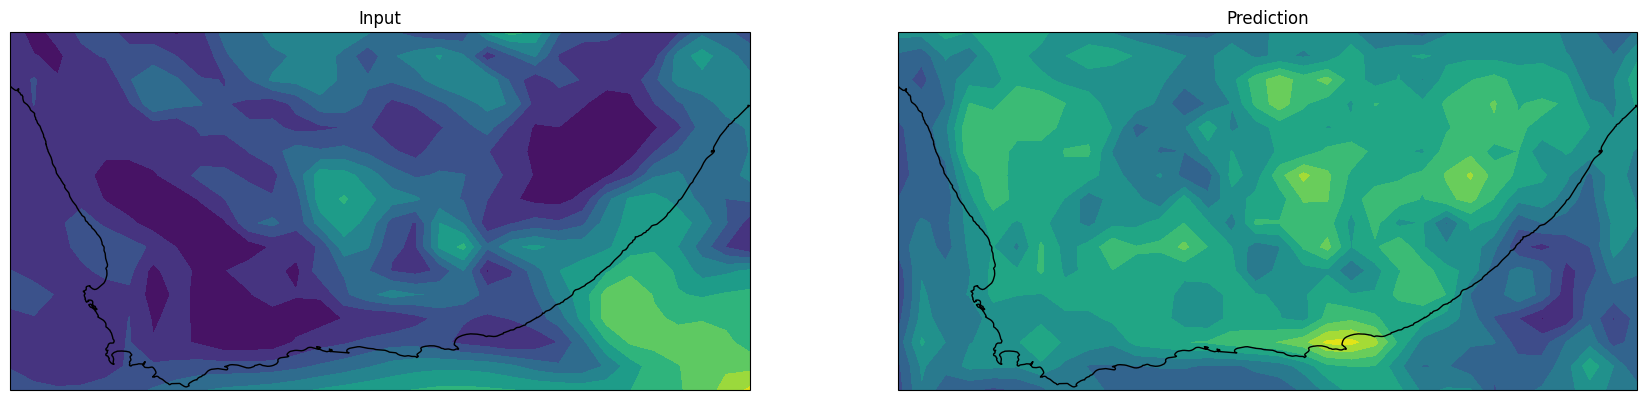

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    ax.set_extent([ds.longitude.min().item(), ds.longitude.max().item(), ds.latitude.min().item(), ds.latitude.max().item()], crs=ccrs.PlateCarree())
    ax.coastlines()

axs[0].set_title('Input')
axs[1].set_title('Prediction')

feat = axs[0].contourf(ds.longitude, ds.latitude, X_train_tensor[0, 0].numpy(), levels=10, transform=ccrs.PlateCarree())
tar = axs[1].contourf(ds.longitude, ds.latitude, prediction[0, 0].detach().numpy(), levels=10, transform=ccrs.PlateCarree())